# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

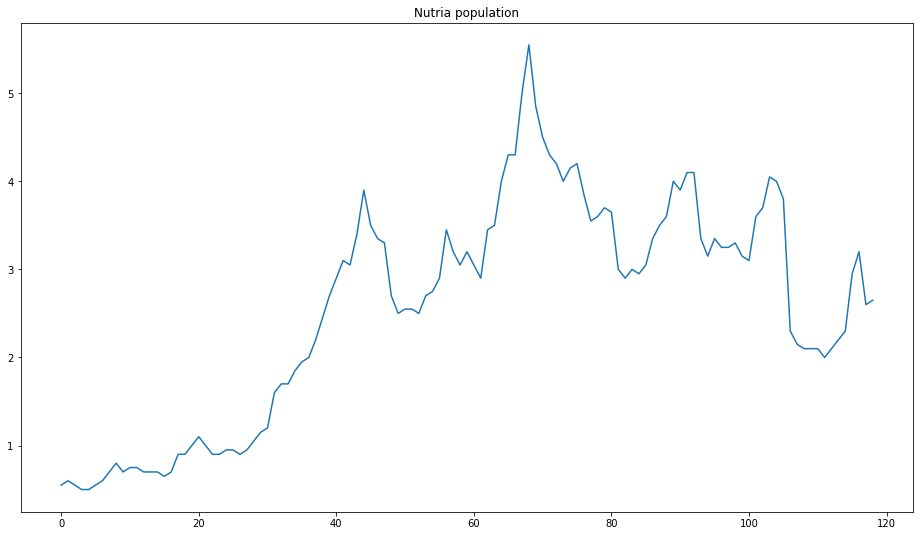

In [1]:
import pandas as pd

data = pd.read_csv('nutria.txt', sep='\t').iloc[:, 0].rename('nutria')

data.plot(figsize=(16, 9), title='Nutria population')

Next, we'll specify the model to use for inference. We'll use the flexible Allee model, found in .. . However, instead of considering the actual population, we'll use the logarithm.

In [2]:
from pyfilter.timeseries import LinearGaussianObservations, AffineProcess
from torch.distributions import Normal, Gamma, TransformedDistribution, AffineTransform, PowerTransform
import torch

torch.set_default_tensor_type(torch.cuda.FloatTensor)

def f(x, a, b, c, d):
    exped = x.exp()
    return x + a + b * exped + c * exped ** 2


def g(x, a, b, c, d):
    return d.sqrt()


alpha = data.shape[0] / 2
beta = 2 * (alpha - 1) / 10

invgamma = TransformedDistribution(Gamma(alpha, beta), PowerTransform(-1.))

h_priors = Normal(0., 1.), Normal(0., 1.), Normal(0., 1.), invgamma
dist = Normal(0., 1.)
hidden = AffineProcess((f, g), h_priors, dist, dist)

model = LinearGaussianObservations(hidden, 1., invgamma)

Next, we'll use SMC2 together with APF to perform inference on the logged dataset.

In [3]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters import APF
import numpy as np


logged_data = torch.from_numpy(np.log(data).values).float().cuda()

algs = list()
for i in range(2):
    filt = APF(model.copy(), 400)
    alg = SMC2(filt, 1000, threshold=.5)
    state = alg.fit(logged_data)
    
    algs.append((state, alg))

SMC2: 100%|██████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 25.09it/s]


Next, let's visualize the filtered means of the state.

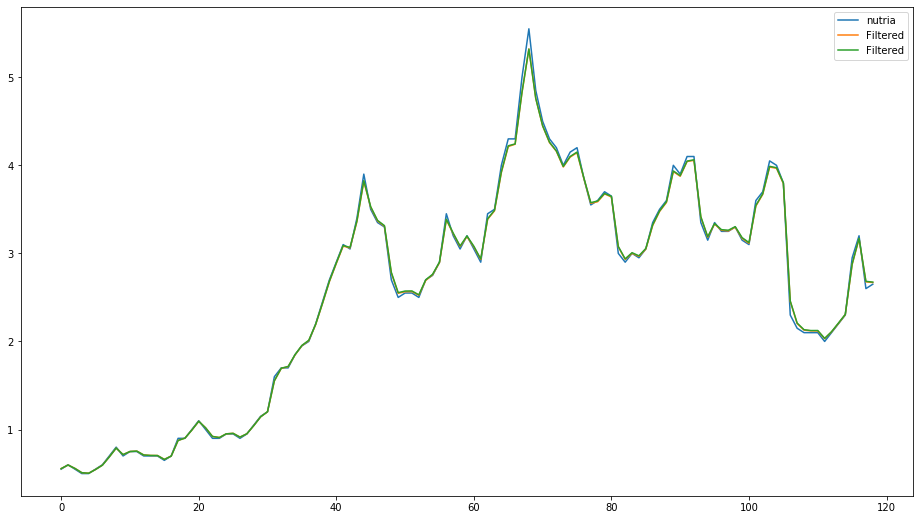

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

data.plot(ax=ax)

for state, _ in algs:
    ax.plot(state.filter_state.filter_means.mean(dim=1).exp().cpu().numpy(), label='Filtered')

ax.legend()

Next, let's visualize the posterior distributions of the parameters.

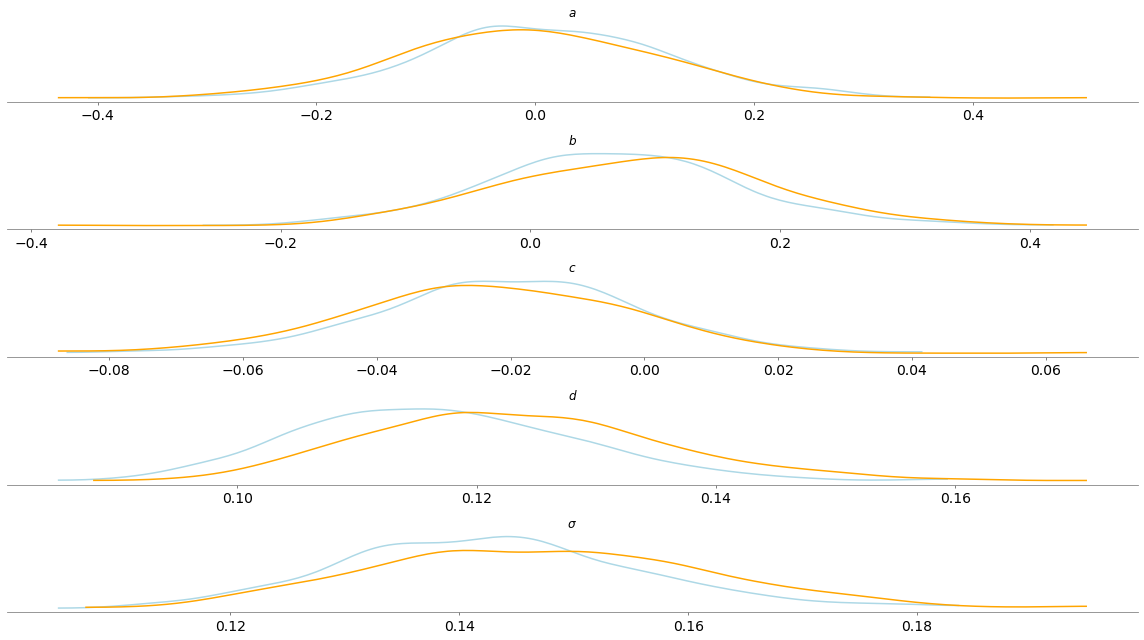

In [11]:
from pyfilter.utils import normalize
import pandas as pd
from arviz import plot_posterior

fig, ax = plt.subplots(len(alg.filter.ssm.trainable_parameters), figsize=(16, 9))
colors = ["lightblue", "orange"]

names = "a, b, c, d, \sigma".split(", ")

for j, (state, alg) in enumerate(algs):
    w = normalize(state.w)
    for i, param in enumerate(alg.filter.ssm.trainable_parameters):
        plot_posterior(param.cpu().numpy(), ax=ax[i], color=colors[j], point_estimate=None, hdi_prob='hide')
        ax[i].set_title(f"${names[i]}$")

plt.tight_layout()